In [4]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
from sentence_transformers import SentenceTransformer, util


# Assuming `embeddings` is your input array of sentence BERT embeddings
IMDB_data = pd.read_csv("C:/Users/ImDB/Desktop/Github/IMDB Dataset.csv")

corpus = IMDB_data['review'][0:500].tolist()

model = SentenceTransformer("multi-qa-MiniLM-L6-cos-v1")

embeddings = model.encode(corpus)

In [11]:
print((embeddings))

[[ 0.06133335 -0.00153739  0.01101304 ... -0.05674137 -0.05998546
   0.00572165]
 [-0.01865691 -0.00396714  0.01732819 ...  0.01713451 -0.0703722
   0.05126088]
 [ 0.01821671 -0.07744378  0.06836674 ...  0.06500142 -0.06226609
  -0.09545532]
 ...
 [-0.0137647  -0.01875843  0.00655315 ...  0.09457693 -0.04050808
  -0.01577168]
 [ 0.0036968   0.05918504  0.01989739 ... -0.04618411 -0.03051618
  -0.03107903]
 [ 0.0029626  -0.01078619  0.09103169 ...  0.03723548  0.02870917
   0.03831155]]


In [12]:
# Step 1: Standardize the Embeddings
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# Step 2: Cluster the Embeddings
num_clusters = 20
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(embeddings_scaled)

# Step 3: Create a Single Embedding for Each Cluster
cluster_embeddings = []
for cluster in range(num_clusters):
    cluster_members = embeddings[cluster_labels == cluster]
    cluster_centroid = np.mean(cluster_members, axis=0)
    cluster_embeddings.append(cluster_centroid)

cluster_embeddings = np.array(cluster_embeddings)

# Step 4: (Optional) Evaluate the Clustering
silhouette_avg = silhouette_score(embeddings_scaled, cluster_labels)
print(f'Silhouette Score: {silhouette_avg}')


Silhouette Score: 0.005590459797531366


In [13]:
print(cluster_embeddings.shape)

(20, 384)


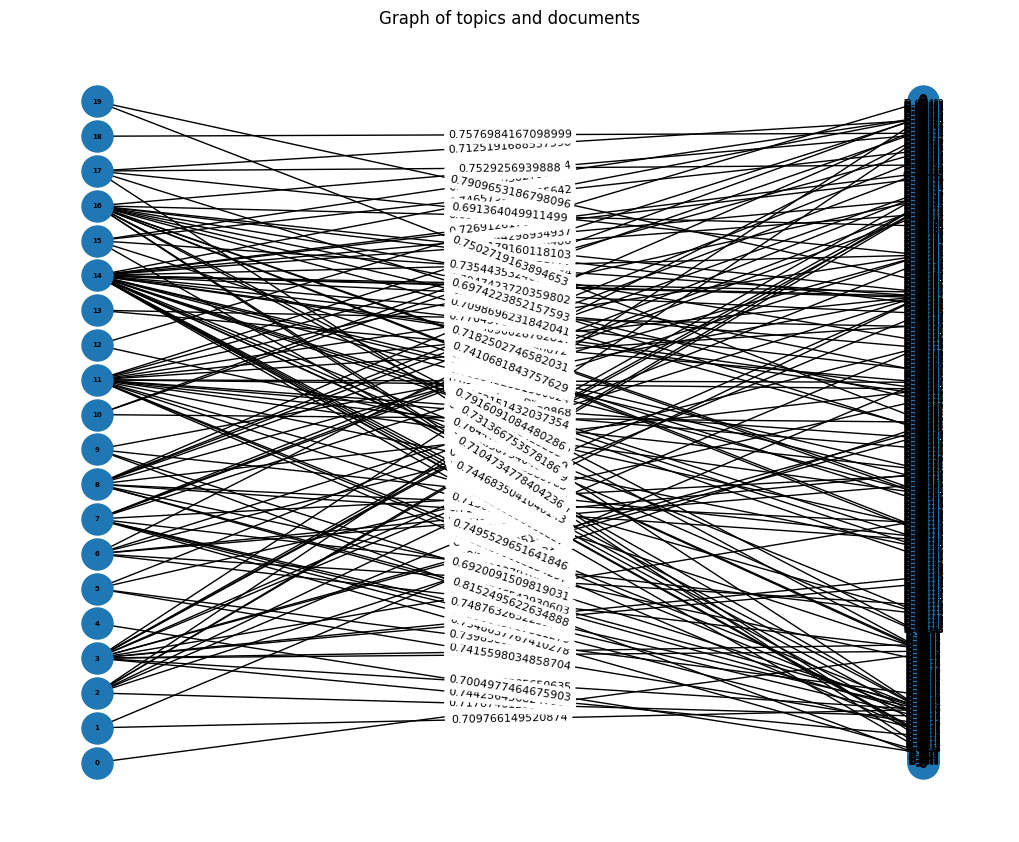

In [26]:
import networkx as nx
import matplotlib.pyplot as plt
# Set similarity threshold
threshold = 0.69

# Create graph
G = nx.Graph()

# Add topics as nodes
for i, topic_embedding in enumerate(cluster_embeddings):
    G.add_node(i, type='topic', bipartite=0, embedding=np.array2string(topic_embedding, separator=',').strip('[]')) 
    #print(len(np.array2string(topic_embedding, separator=',').strip('[]')))


# Add documents as nodes and connect to topics based on similarity
for i, doc_embedding in enumerate(embeddings):
    G.add_node(f"ID_doc{i}", type='ID document', bipartite=1, label=0, embedding=np.array2string(doc_embedding, separator=',').strip('[]'))
    #print(len(np.array2string(doc_embedding, separator=',').strip('[]')))
    for j, topic_embedding in enumerate(cluster_embeddings):
        similarity = util.cos_sim(topic_embedding, doc_embedding)
        #print(similarity, j)
        #print(np.linalg.norm(doc_embedding))
        if similarity > threshold:
            G.add_edge(j, f"ID_doc{i}", weight=similarity[0][0].item())

#nx.write_graphml(G, '5000ID_2500OOD_4NNsfsgsg.graphml')

topics = [0, 1, 2, 3, 4, 5 ,6 ,7 ,8 ,9 ,10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
# Plot graph
plt.figure(figsize=(10,8))
pos = nx.bipartite_layout(G, topics)
#nx.draw_networkx_nodes(G, pos, nodelist=topics, node_color='r', label="topics")
#nx.draw_networkx_nodes(G, pos, nodelist=doc_embeddings, node_color='b', label="document")
nx.draw(G, pos, with_labels=True, node_size=500, font_size=5, font_weight='bold')
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size = 8)
labels = nx.get_node_attributes(G, 'label')
nx.draw_networkx_labels(G, pos, labels=labels)
plt.title('Graph of topics and documents')
plt.show()





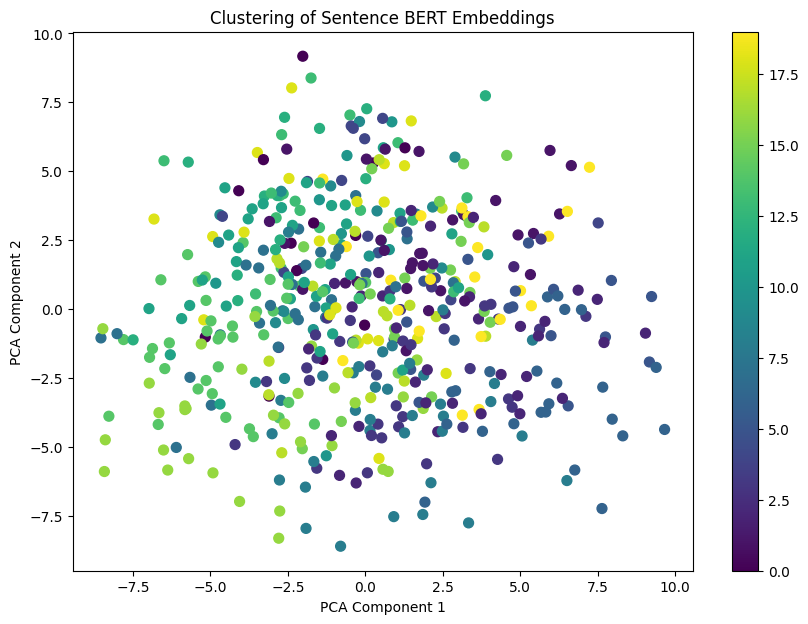

In [30]:
from sklearn.decomposition import PCA

# Step 2: Reduce Dimensionality for Visualization (Optional)
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings_scaled)

# Step 5: Visualize the Clusters (Optional)
plt.figure(figsize=(10, 7))
scatter = plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=cluster_labels, cmap='viridis', s=50)
plt.colorbar(scatter)
plt.title('Clustering of Sentence BERT Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()